In [32]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# plt.style.use('dark_background')
import warnings
warnings.filterwarnings('ignore') 

start = time.perf_counter()

In [33]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602 entries, 0 to 601
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            602 non-null    object 
 1   Player          602 non-null    object 
 2   MatchId         602 non-null    object 
 3   Map             602 non-null    object 
 4   Category        602 non-null    object 
 5   Playlist        602 non-null    object 
 6   Input           602 non-null    object 
 7   Queue           602 non-null    object 
 8   Csr             602 non-null    int64  
 9   Mmr             1 non-null      float64
 10  Outcome         602 non-null    object 
 11  Accuracy        602 non-null    float64
 12  DamageDone      602 non-null    int64  
 13  DamageTaken     602 non-null    int64  
 14  ShotsFired      602 non-null    int64  
 15  ShotsLanded     602 non-null    int64  
 16  ShotsMissed     602 non-null    int64  
 17  KD              602 non-null    flo

In [34]:
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']
df['ExcessKD'] = df['KD'] - round((df['ExpectedKills'] / df['ExpectedDeaths']),2)
df['LifetimeKD'] = df['Kills'].cumsum() / df['Deaths'].cumsum()
df['LifetimeDmgRatio'] = df['DamageDone'].cumsum() / df['DamageTaken'].cumsum()
df['LifetimeAcc'] = df['ShotsLanded'].cumsum() / df['ShotsFired'].cumsum() * 100
df['Map'] = df['Map'].str.replace(' - Ranked', '')

df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr'],axis=1)
dfr = df[df['Date']> '2023-01-01']
dfr = dfr[dfr['Playlist'] == 'Ranked Arena']
dfr['Csr'] = dfr['Csr'].replace(0, method='ffill')
dfr = dfr[dfr['Outcome'] != 'Draw']
dfr = dfr[dfr['Outcome'] != 'Left']
dfr['Outcome'] = dfr['Outcome'].map({'Win': 1, 'Loss': 0})
dfr['LifetimeWinRate'] = (dfr['Outcome'].cumsum() / 
                          (dfr['Outcome'].cumsum() + 
                           dfr['Outcome'].eq(0).cumsum())).fillna(0)
dfr = dfr.drop('Playlist', axis=1).reset_index()
dfr.loc[:4, 'Csr'] = 808
dfr.to_csv('df.csv')
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   index             388 non-null    int64         
 1   Date              388 non-null    datetime64[ns]
 2   Map               388 non-null    object        
 3   Category          388 non-null    object        
 4   Csr               388 non-null    int64         
 5   Outcome           388 non-null    int64         
 6   Accuracy          388 non-null    float64       
 7   DamageDone        388 non-null    int64         
 8   DamageTaken       388 non-null    int64         
 9   ShotsFired        388 non-null    int64         
 10  ShotsLanded       388 non-null    int64         
 11  ShotsMissed       388 non-null    int64         
 12  KD                388 non-null    float64       
 13  KDA               388 non-null    float64       
 14  Kills             388 non-

In [35]:
dfr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,388.0,372.126289,133.066932,140.000000,262.750000,371.500000,484.250000,601.000000
Csr,388.0,956.726804,53.610208,790.000000,935.750000,961.500000,994.000000,1058.000000
Outcome,388.0,0.533505,0.499520,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,388.0,51.762010,5.565222,24.390000,48.580000,52.020000,54.792500,80.560000
DamageDone,388.0,5090.087629,1830.840163,347.000000,3776.250000,4774.000000,6277.250000,12673.000000
DamageTaken,388.0,4403.432990,1551.371126,276.000000,3388.000000,4150.500000,5343.750000,9962.000000
ShotsFired,388.0,230.018041,78.868826,16.000000,178.750000,219.000000,287.250000,468.000000
ShotsLanded,388.0,118.865979,42.102282,4.000000,91.750000,112.000000,147.250000,281.000000
ShotsMissed,388.0,111.152062,40.122230,7.000000,84.000000,107.000000,137.250000,261.000000
KD,388.0,1.236675,0.668697,0.000000,0.850000,1.120000,1.430000,6.000000


In [89]:
print("Kills           ", dfr.Kills.sum())
print("Expected Kills  ", round(dfr.ExpectedKills.sum(),))
print("Deaths          ", dfr.Deaths.sum())
print("Expected Deaths ", round(dfr.ExpectedDeaths.sum(),))
print("KD              ", round(dfr.Kills.sum() / dfr.Deaths.sum(),2))
print("Excepcted KD    ", round(dfr.ExpectedKills.sum() / dfr.ExpectedDeaths.sum(),2))


Kills            5561
Expected Kills   5525
Deaths           4964
Expected Deaths  5468
KD               1.12
Excepcted KD     1.01


In [71]:
dfr.tail()

,index,Date,Map,Category,Csr,Outcome,Accuracy,DamageDone,DamageTaken,ShotsFired,...,SmoothedDmgRatio,SmoothedKD,SmoothedWinRate,SmoothedKills,SmoothedDeaths,SmoothedAssists,SmoothedDmg,SmoothedDmgT,SmoothedExKills,SmoothedExDeaths
383,597,2024-01-10 04:27:37,Solitude,King of the Hill,1001,0,50.00,4072,4343,214,...,1.111428,0.994609,0.44,12.96,14.40,10.36,4765.599957,4299.003107,15.82,15.70
384,598,2024-01-10 04:37:13,Live Fire,King of the Hill,993,1,46.75,5500,3862,308,...,1.110853,1.000000,0.44,12.80,14.12,10.20,4775.128236,4290.343468,15.76,15.58
385,599,2024-01-10 04:48:15,Streets,Oddball,1002,0,41.94,4041,5199,186,...,1.101448,0.995890,0.44,12.92,14.12,9.92,4764.546455,4287.656787,15.70,15.54
386,600,2024-01-10 05:00:19,Aquarius,Slayer,994,1,49.04,3697,2813,157,...,1.113165,0.994398,0.48,13.04,13.92,9.84,4790.945183,4265.565021,15.56,15.40
387,601,2024-01-10 05:13:24,Streets,Slayer,1002,1,46.63,4121,3472,208,...,1.114647,1.008451,0.48,13.24,13.64,9.24,4808.384113,4278.947974,15.58,15.42


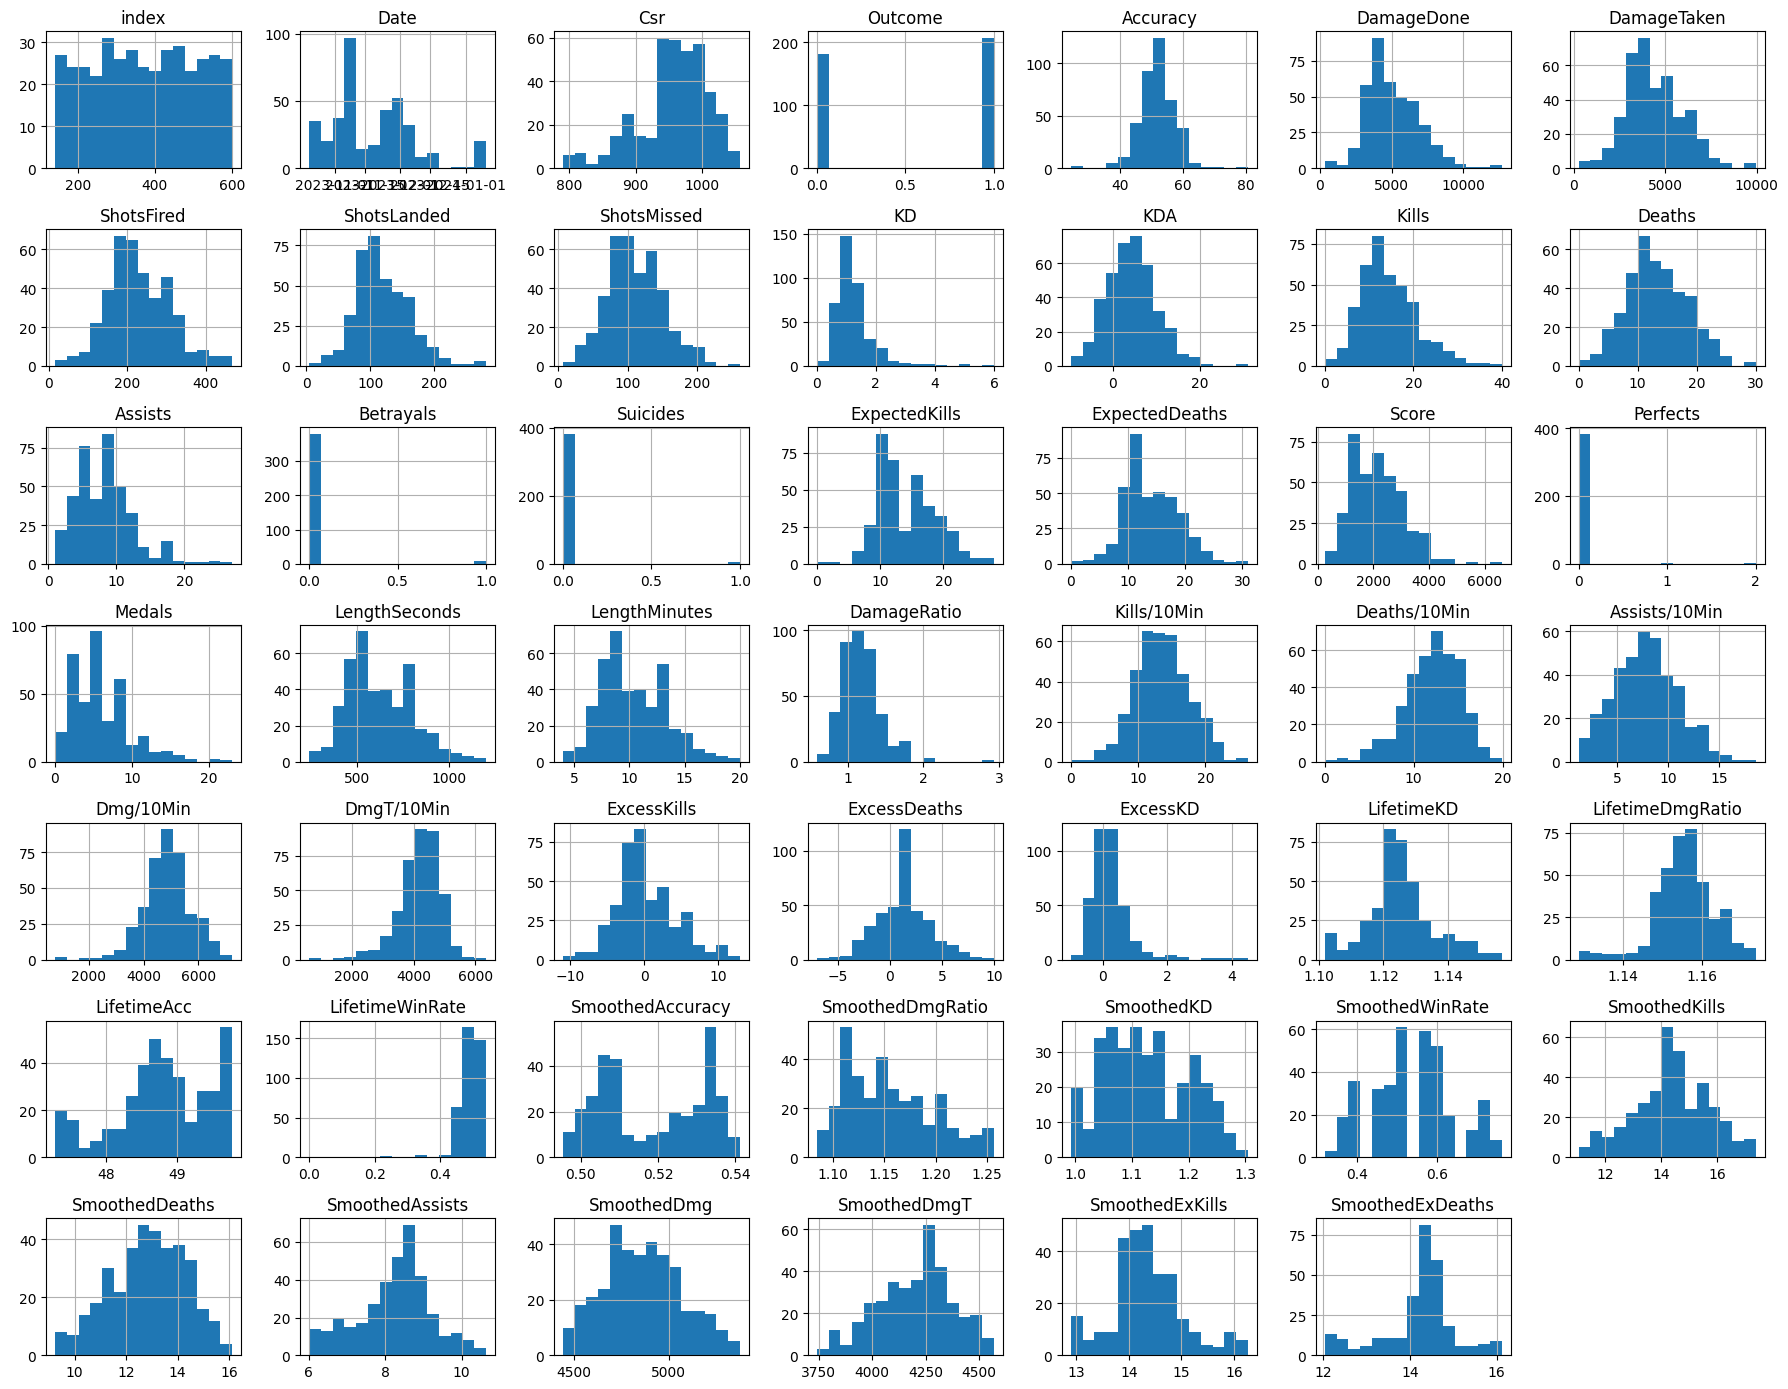

In [90]:
dfr.hist(bins=15, figsize=(18, 14))
plt.tight_layout()
plt.show()

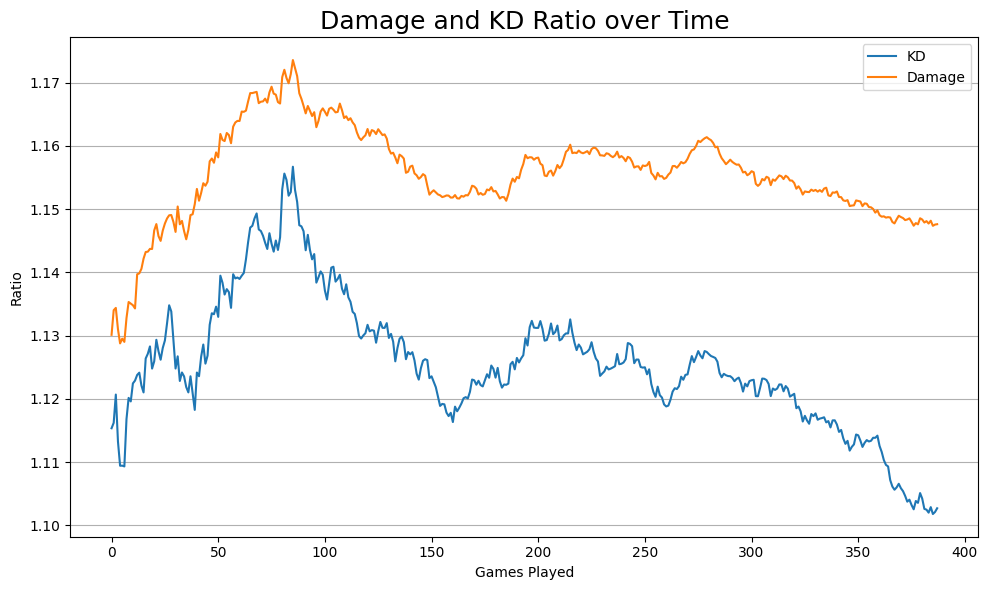

In [39]:
plt.figure(figsize=(10,6))
plt.plot(dfr['LifetimeKD'], label='KD' )
plt.plot(dfr['LifetimeDmgRatio'], label='Damage')
plt.title('Damage and KD Ratio over Time', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('Plots/DamKDRatios.png', dpi=300)
plt.show()

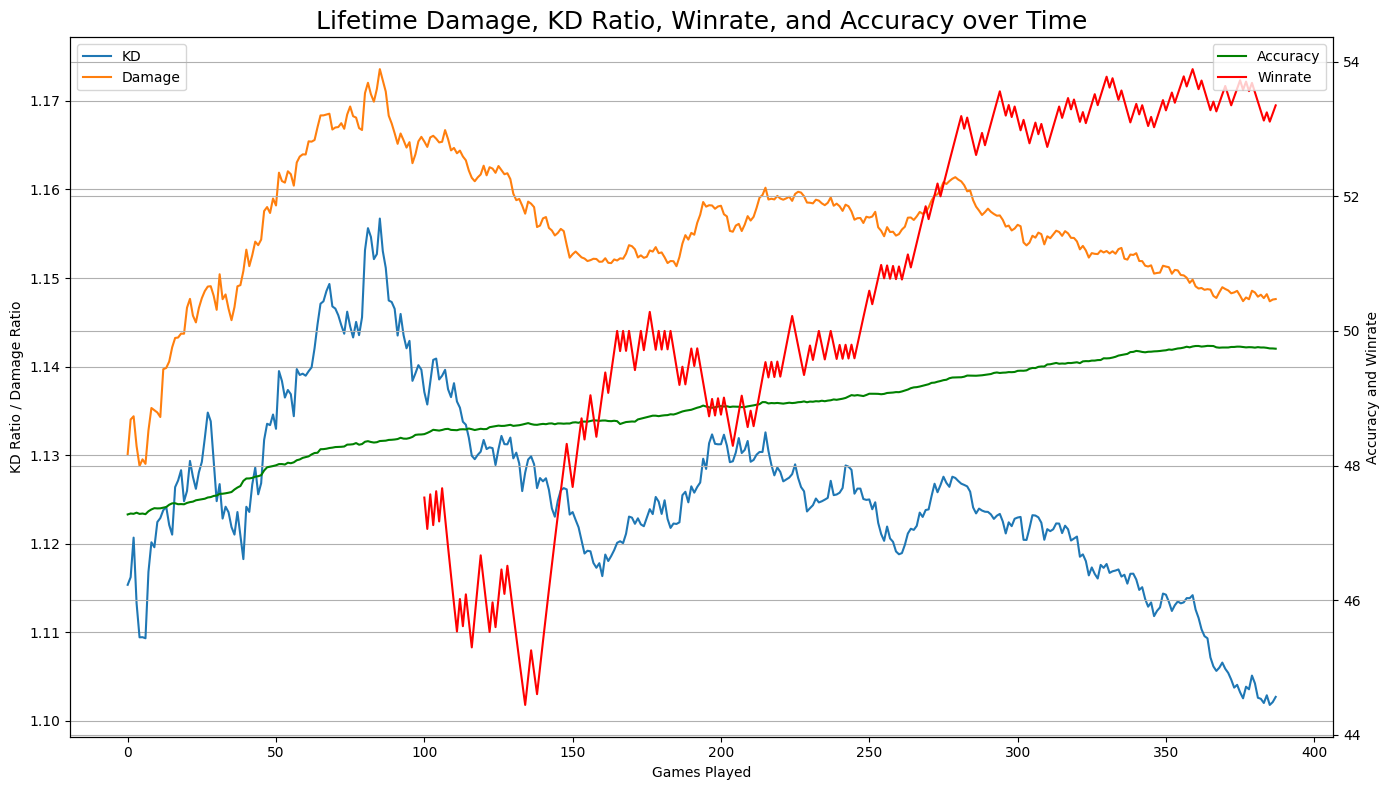

In [40]:
# Smooth the LifetimeWinRate using a 10-game moving average
# dfr['SmoothedAccuracy'] = dfr['Accuracy'].rolling(window=25).mean()

plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['LifetimeAcc'], color='green', label='Accuracy')
ax2.plot(dfr['LifetimeWinRate'][100:]*100, color='red', label='Winrate')
ax1.set_title('Lifetime Damage, KD Ratio, Winrate, and Accuracy over Time', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('Accuracy and Winrate')
# max_y_value = df['LifetimeAcc'].max()
ax1.yaxis.grid(True)
ax2.yaxis.grid(True)
# ax2.set_yticks(np.arange(47, max_y_value, 0.5))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
# plt.savefig('Plots/DamKDRatiosAcc.png', dpi=300)
plt.show()

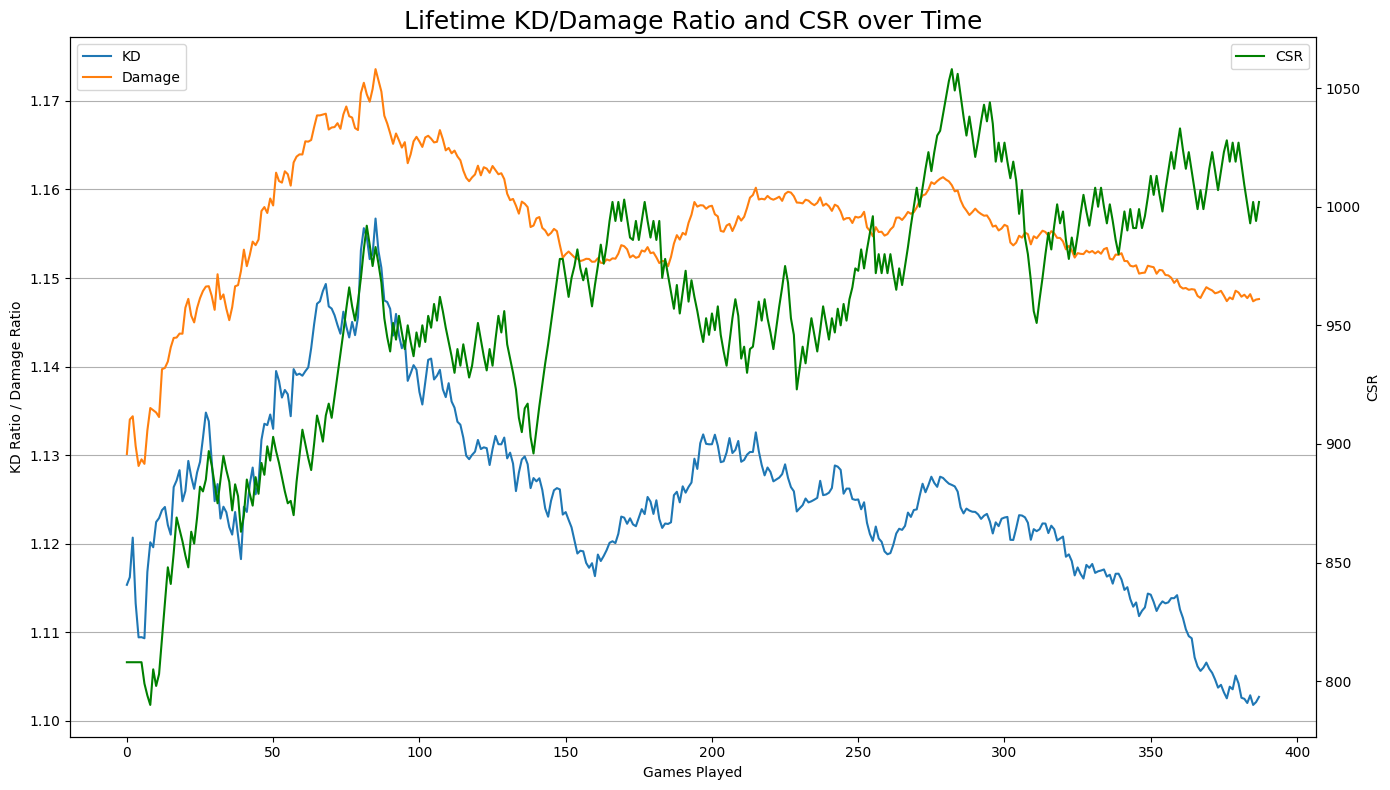

In [41]:
# Smooth the LifetimeWinRate using a 10-game moving average
# dfr['SmoothedAccuracy'] = dfr['Accuracy'].rolling(window=25).mean()

plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['Csr'], color='green', label='CSR')
ax1.set_title('Lifetime KD/Damage Ratio and CSR over Time', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('CSR')
# max_y_value = df['LifetimeAcc'].max()
ax1.yaxis.grid(True)
# ax2.set_yticks(np.arange(47, max_y_value, 0.5))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
# plt.savefig('Plots/DamKDRatiosAcc.png', dpi=300)
plt.show()

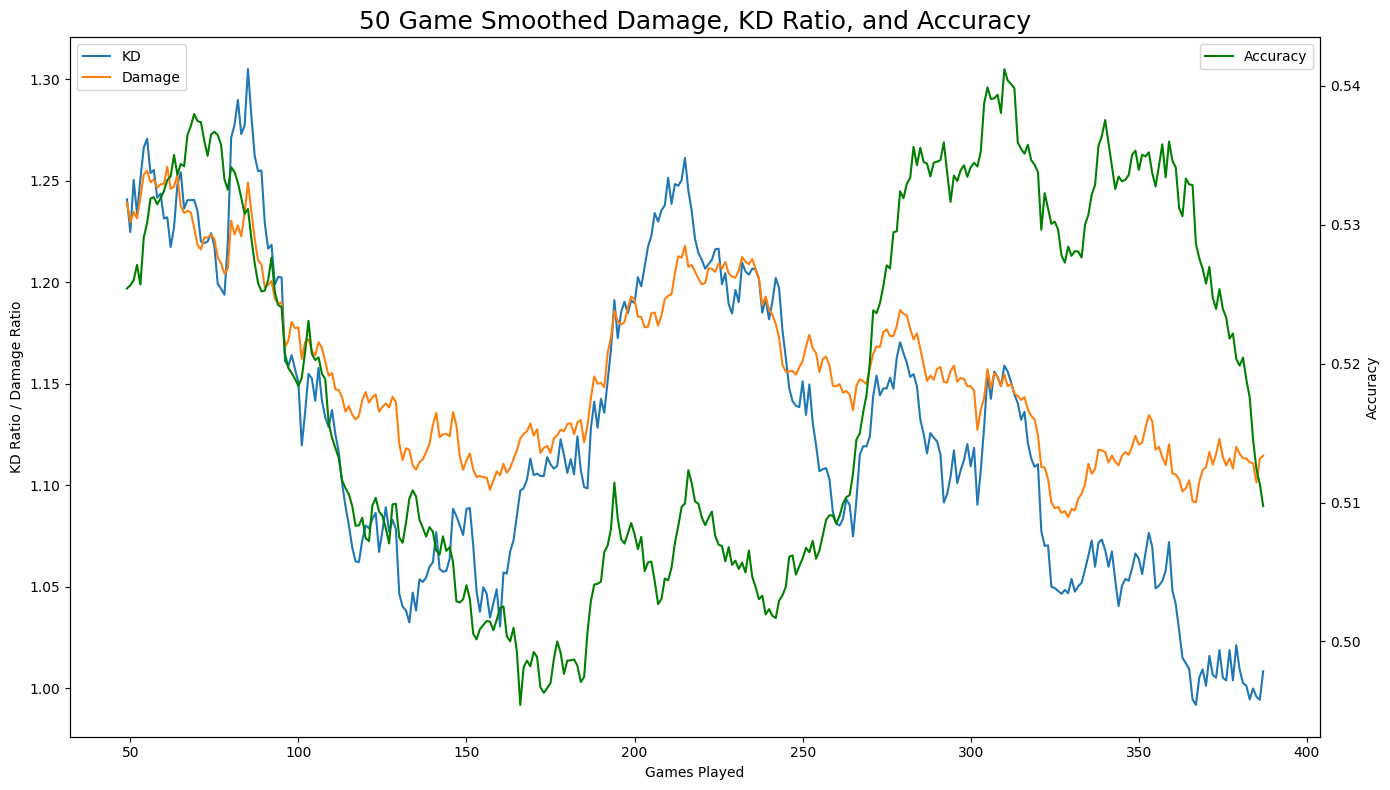

In [42]:
# Smooth the LifetimeWinRate using a 10-game moving average
# Set roll to ** game moving average
roll = 50
dfr['SmoothedAccuracy'] = dfr['ShotsLanded'].rolling(window=roll).sum() / dfr['ShotsFired'].rolling(window=roll).sum()
dfr['SmoothedDmgRatio'] = dfr['DamageDone'].rolling(window=roll).sum() / dfr['DamageTaken'].rolling(window=roll).sum()
dfr['SmoothedKD'] = dfr['Kills'].rolling(window=roll).sum() / dfr['Deaths'].rolling(window=roll).sum()


plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['SmoothedKD'], label='KD' )
ax1.plot(dfr['SmoothedDmgRatio'], label='Damage')
ax2.plot(dfr['SmoothedAccuracy'], color='green', label='Accuracy')
ax1.set_title(f'{roll} Game Smoothed Damage, KD Ratio, and Accuracy', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('Accuracy')
max_y_value = df['Accuracy'].max()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/DamKDRatiosAccSmooth.png', dpi=300)
plt.show()

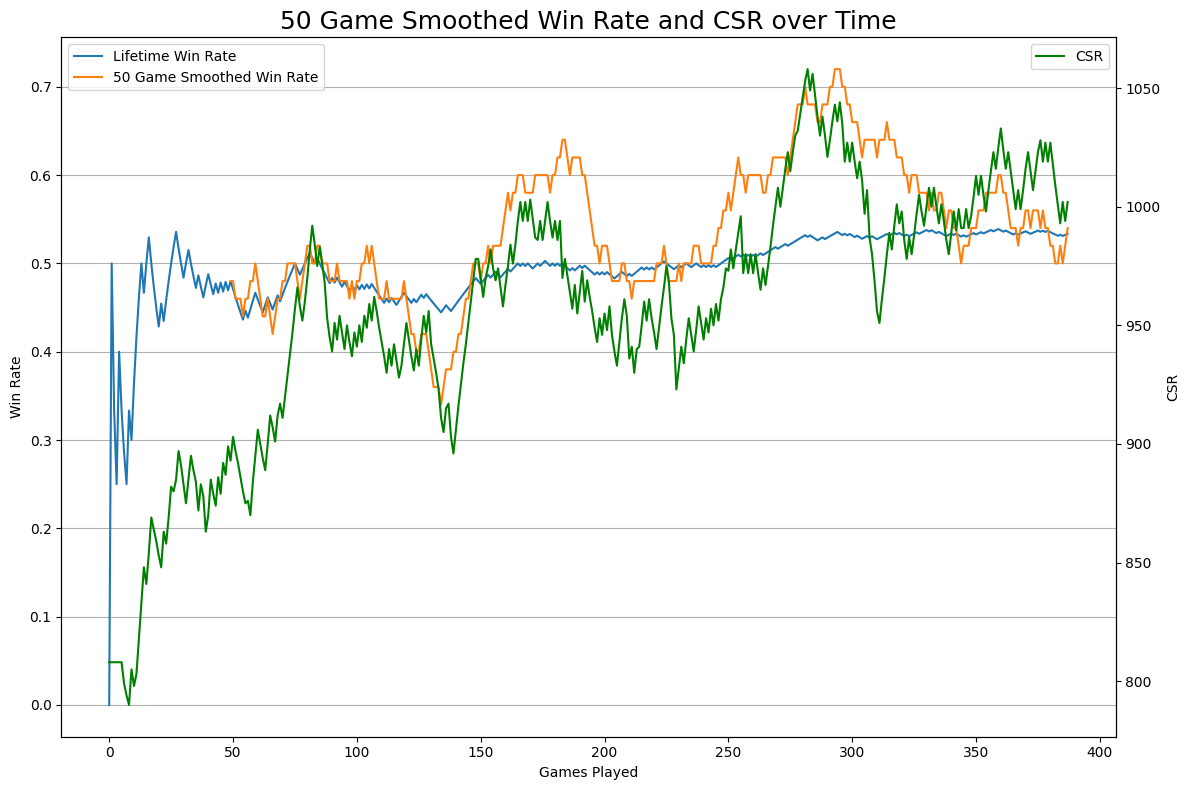

In [43]:
# Smooth the LifetimeWinRate using a 10-game moving average
# dfr['SmoothedWinRate'] = dfr['LifetimeWinRate'].rolling(window=15).mean()
roll = 50
dfr['SmoothedWinRate'] = dfr['Outcome'].rolling(window=roll).sum() / dfr['Outcome'].rolling(window=roll).count()

plt.figure(figsize=(12,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeWinRate'], label='Lifetime Win Rate' )
ax1.plot(dfr['SmoothedWinRate'], label=(f'{roll} Game Smoothed Win Rate'))
ax2.plot(dfr['Csr'], color='green', label='CSR')
ax1.set_title(f'{roll} Game Smoothed Win Rate and CSR over Time', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('Win Rate')
ax2.set_ylabel('CSR')
ax1.yaxis.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/WinRateCSR.png', dpi=300)
plt.show()

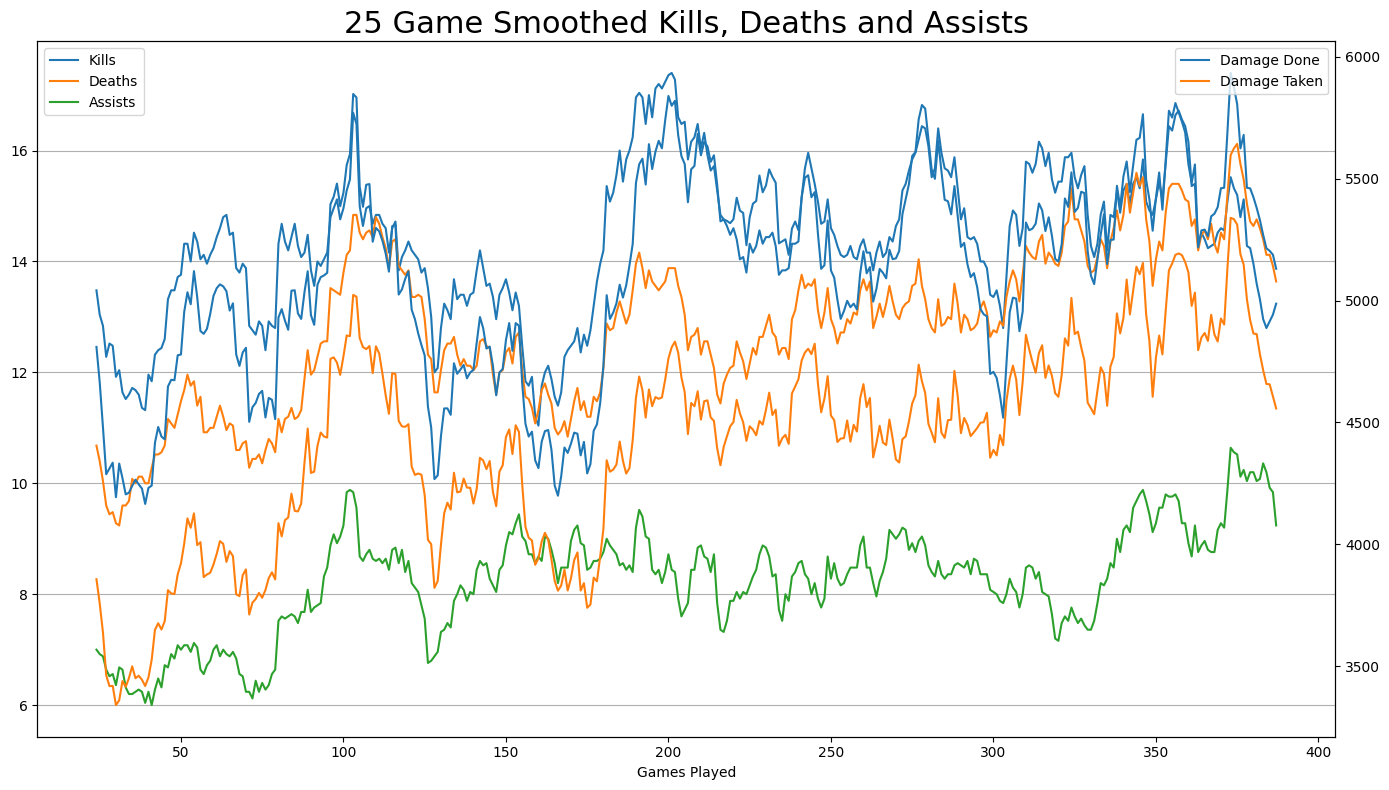

In [44]:
# Smooth the LifetimeWinRate using a 10-game moving average
# Set roll to ** game moving average
roll = 25
dfr['SmoothedKills'] = dfr['Kills'].rolling(window=roll).mean() 
dfr['SmoothedDeaths'] = dfr['Deaths'].rolling(window=roll).mean() 
dfr['SmoothedAssists'] = dfr['Assists'].rolling(window=roll).mean()
dfr['SmoothedDmg'] = dfr['DamageDone'].rolling(window=roll).mean()
dfr['SmoothedDmgT'] = dfr['DamageTaken'].rolling(window=roll).mean()


plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = plt.twinx(ax1)
ax1.plot(dfr['SmoothedKills'], label='Kills' )
ax1.plot(dfr['SmoothedDeaths'], label='Deaths')
ax1.plot(dfr['SmoothedAssists'], label='Assists')
ax2.plot(dfr['SmoothedDmg'], label='Damage Done')
ax2.plot(dfr['SmoothedDmgT'], label='Damage Taken')
ax1.set_title(f'{roll} Game Smoothed Kills, Deaths and Assists', fontsize=22)
ax1.set_xlabel('Games Played')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_facecolor('red')


ax1.yaxis.grid(True)
plt.tight_layout()
plt.savefig('Plots/KDASmooth.png', dpi=300)
plt.show()

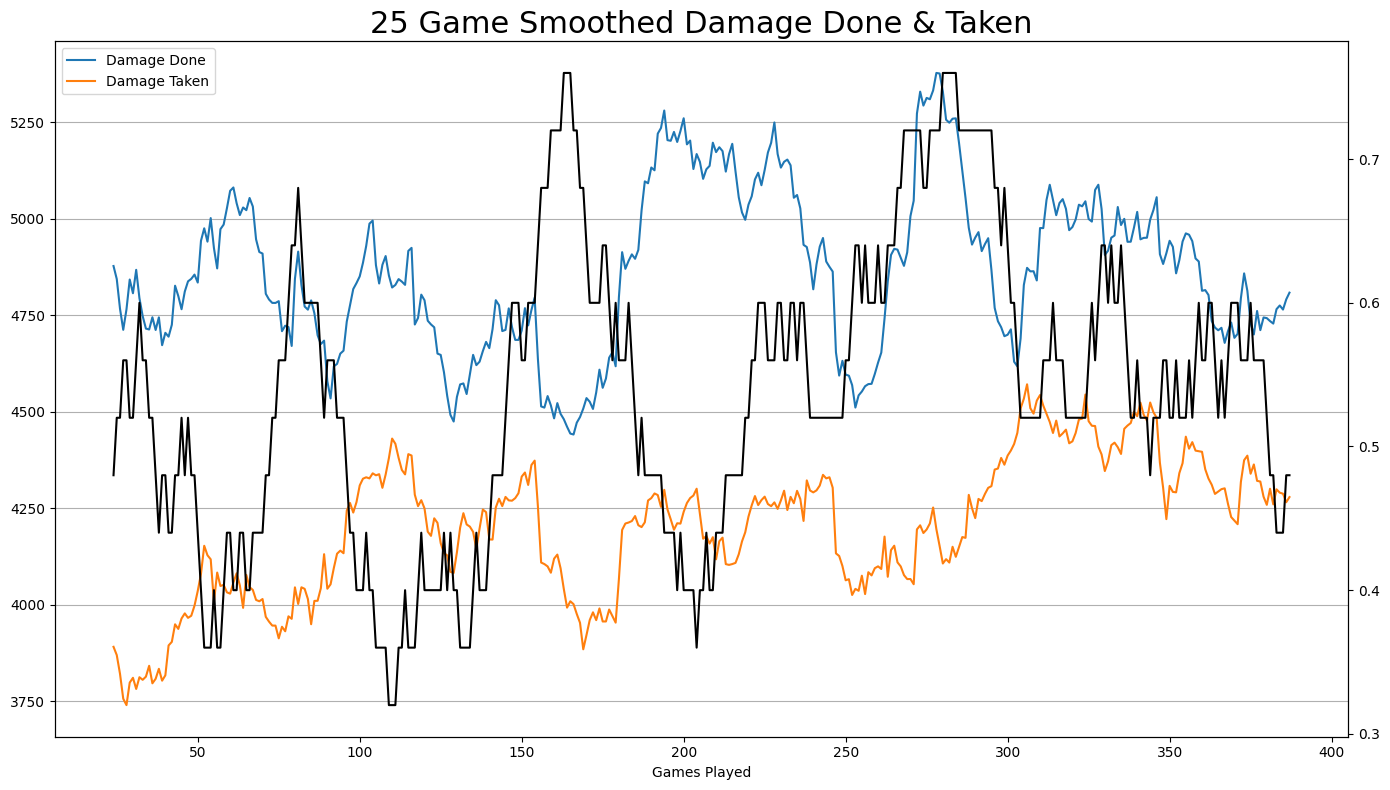

,index,Date,Map,Category,Csr,Outcome,Accuracy,DamageDone,DamageTaken,ShotsFired,...,LifetimeWinRate,SmoothedAccuracy,SmoothedDmgRatio,SmoothedKD,SmoothedWinRate,SmoothedKills,SmoothedDeaths,SmoothedAssists,SmoothedDmg,SmoothedDmgT
0,140,2023-10-19 19:49:41,Solitude,King of the Hill,808,0,52.31,7146,4957,325,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,141,2023-10-19 20:06:10,Solitude,Strongholds,808,1,50.49,7974,5281,309,...,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,142,2023-10-19 20:25:03,Recharge,King of the Hill,808,0,46.36,6889,5906,343,...,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,143,2023-10-19 20:42:40,Streets,Extraction,808,0,53.61,3854,4960,194,...,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,144,2023-10-19 20:55:21,Argyle,CTF 3 Captures,808,1,41.56,2769,3501,231,...,0.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# Smooth the LifetimeWinRate using a 10-game moving average
# Set roll to ** game moving average
roll = 25
dfr['SmoothedDmg'] = dfr['Dmg/10Min'].rolling(window=roll).mean()
dfr['SmoothedDmgT'] = dfr['DmgT/10Min'].rolling(window=roll).mean()
dfr['SmoothedWinRate'] = dfr['Outcome'].rolling(window=roll).sum() / dfr['Outcome'].rolling(window=roll).count()

plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['SmoothedDmg'], label='Damage Done')
ax1.plot(dfr['SmoothedDmgT'], label='Damage Taken')
ax2.plot(dfr['SmoothedWinRate'], label='Winrate', color='black')
ax1.set_title(f'{roll} Game Smoothed Damage Done & Taken', fontsize=22)
ax1.set_xlabel('Games Played')
ax1.legend(loc='upper left')
ax1.yaxis.grid(True)
plt.tight_layout()
plt.savefig('Plots/KDASmooth.png', dpi=300)
plt.show()

dfr.head()

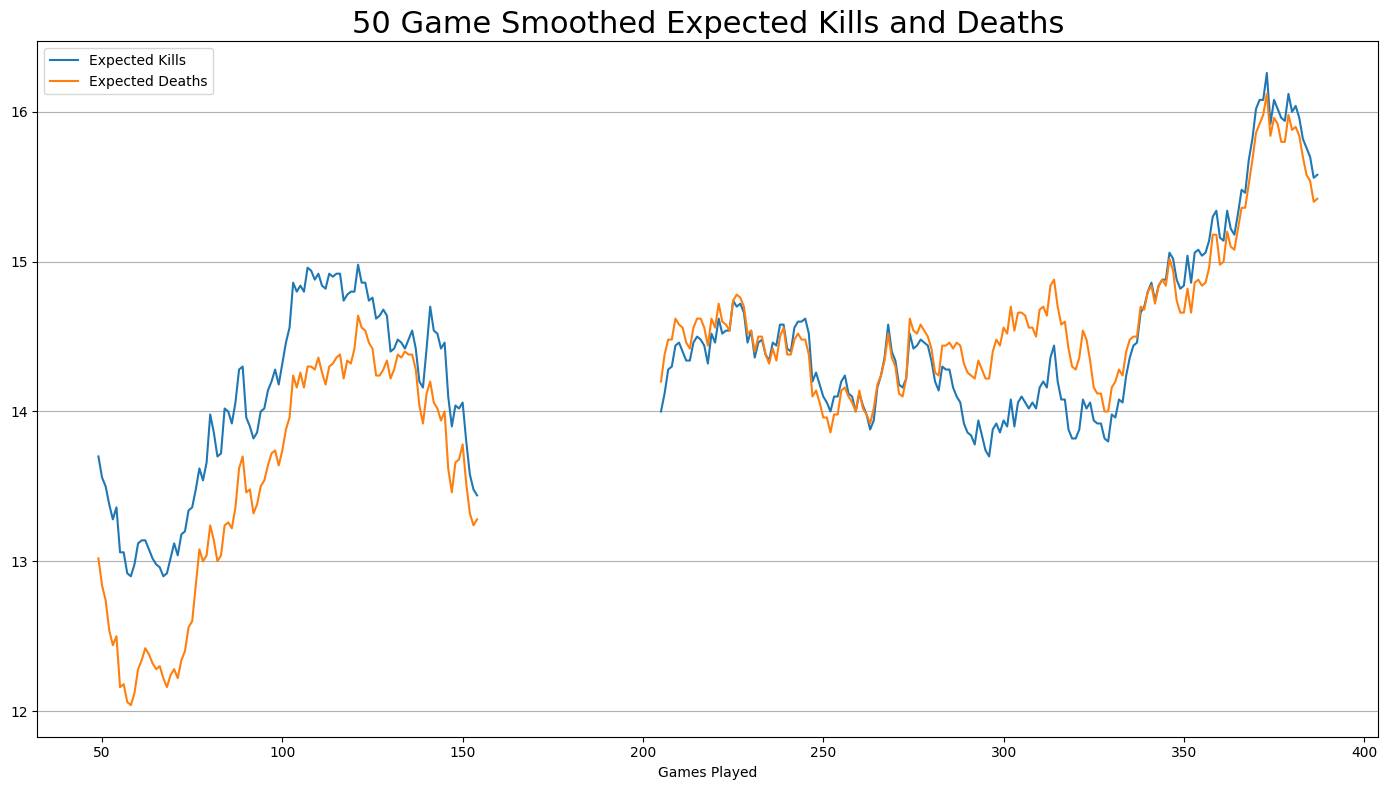

In [46]:
# Smooth the LifetimeWinRate using a 10-game moving average
# Set roll to ** game moving average
roll = 50
dfr['SmoothedExKills'] = dfr['ExpectedKills'].rolling(window=roll).mean()
dfr['SmoothedExDeaths'] = dfr['ExpectedDeaths'].rolling(window=roll).mean()

plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax1.plot(dfr['SmoothedExKills'], label='Expected Kills')
ax1.plot(dfr['SmoothedExDeaths'], label='Expected Deaths')
ax1.set_title(f'{roll} Game Smoothed Expected Kills and Deaths', fontsize=22)
ax1.set_xlabel('Games Played')
ax1.legend(loc='upper left')
ax1.yaxis.grid(True)
plt.tight_layout()
plt.savefig('Plots/ExKDSmooth.png', dpi=300)
plt.show()

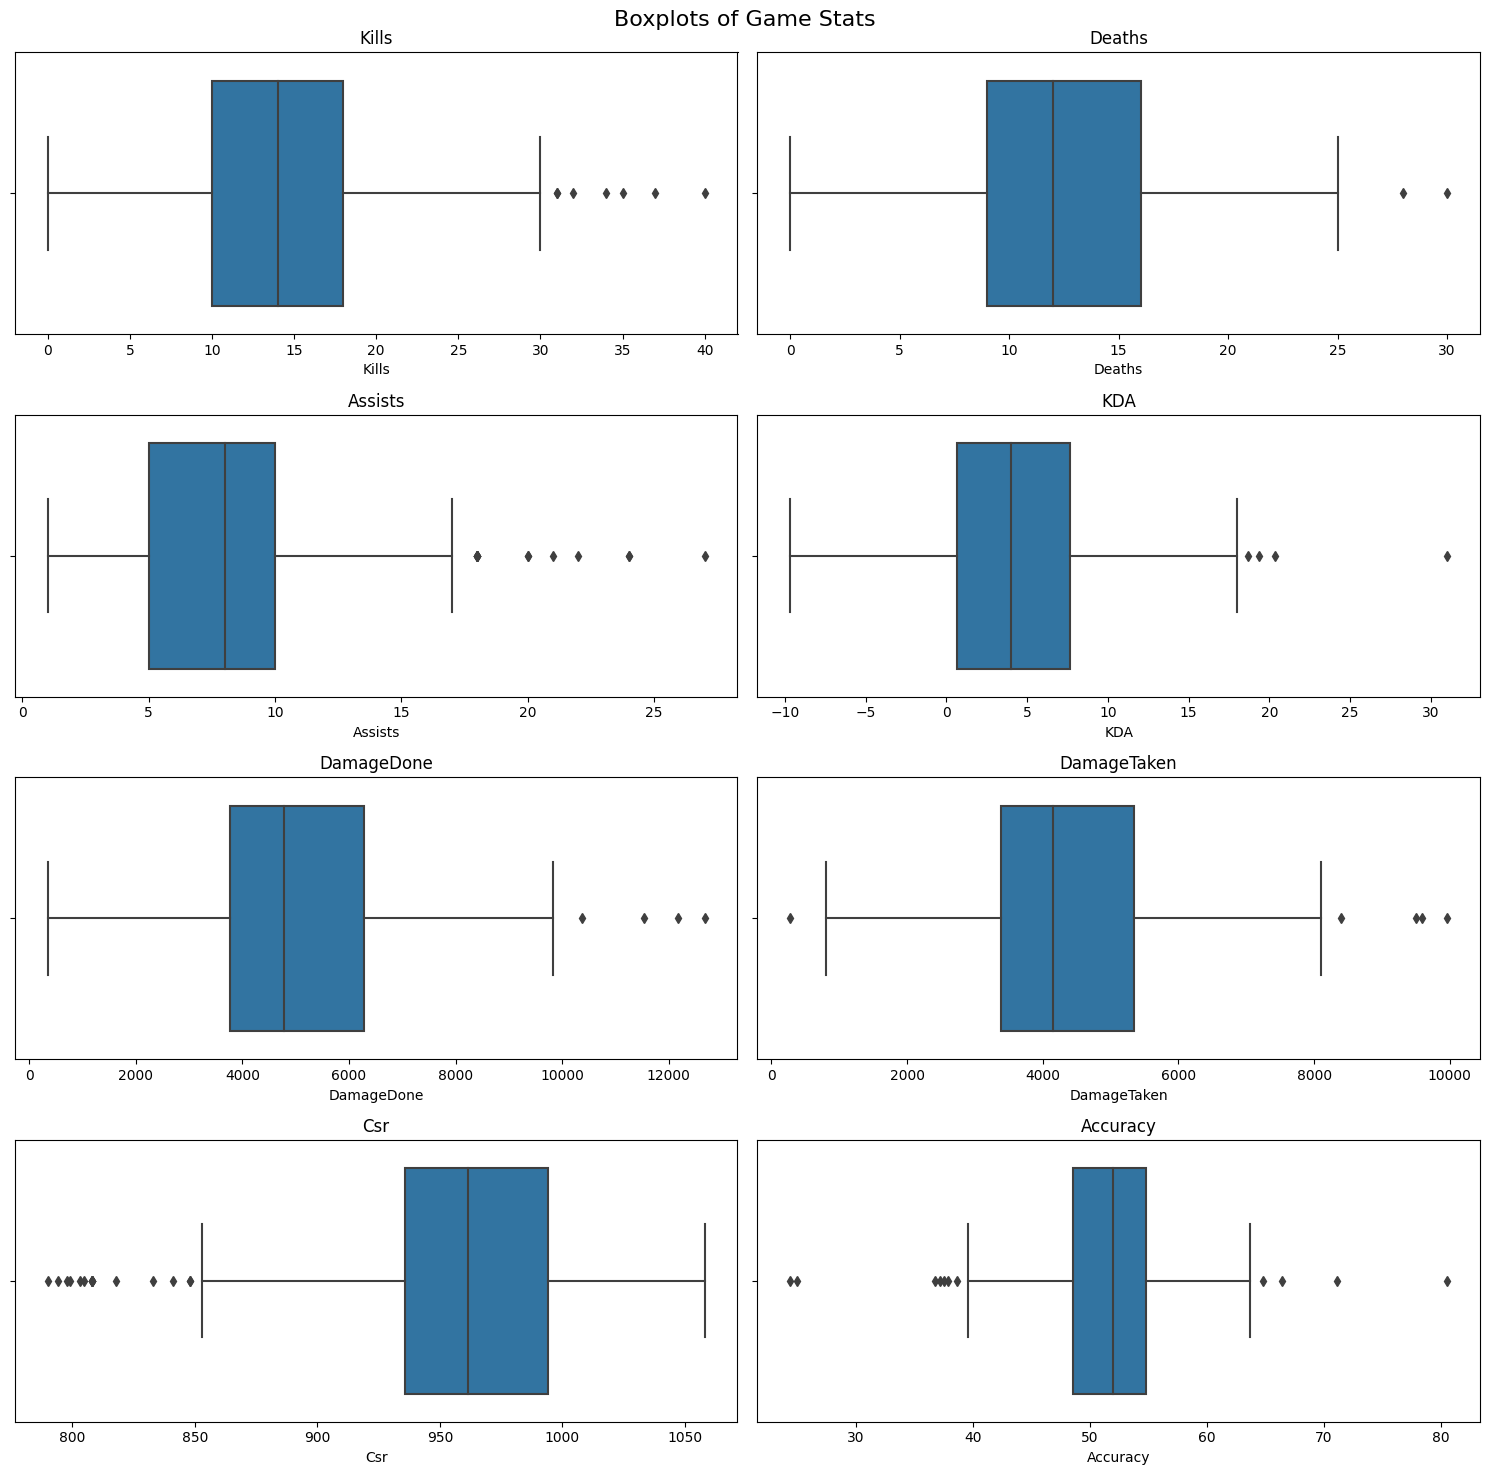

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
columns = ['Kills', 'Deaths', 'Assists', 'KDA', 'DamageDone', 'DamageTaken',
            'Csr', 'Accuracy']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot each column in a separate boxplot
for i, column in enumerate(columns):
    sns.boxplot(x=dfr[column], ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.suptitle('Boxplots of Game Stats', fontsize=16)
plt.tight_layout()
plt.savefig('Plots/Boxplots.png', dpi=300)
plt.show()


In [48]:
mod = 15

# dfmod = dfr.loc[dfr['Deaths'] < mod, 
#                 ['Kills', 'Deaths', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome']
#                 ].sort_values('DamageDone', ascending=False)

# Column Choice <>
# dfmod = dfr.loc[dfr['Deaths'] < mod]

# Last * Games
dfmod = dfr.tail(mod)

# print(dfmod.head())
print(f'Overall KD: {round(dfmod["Kills"].sum() / dfmod["Deaths"].sum(),2)}')
print(f"Accuracy: {round(dfmod['ShotsLanded'].sum() / dfmod['ShotsFired'].sum()*100,2)}")
print(f"Damage Ratio: {round(dfmod['DamageDone'].sum() / dfmod['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfmod['Outcome']==1).sum()}-{(dfmod['Outcome']==0).sum()}")
print(f"Max CSR: {dfmod['Csr'].max()}")

Overall KD: 1.03
Accuracy: 48.51
Damage Ratio: 1.13
Win-Loss: 8-7
Max CSR: 1028


In [49]:
dfw = dfr.loc[dfr['Outcome'] == 1, 
                ['Kills', 'Deaths', 'Assists', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills', ascending=False)

dfl = dfr.loc[dfr['Outcome'] == 0, 
                ['Kills', 'Deaths', 'Assists', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills', ascending=False)

print('Overall')
print(f'Overall KD: {round(dfr["Kills"].sum() / dfr["Deaths"].sum(),2)}')
print(f"Average Kills: {round(dfr['Kills'].mean(),2)}")
print(f"Average Deaths: {round(dfr['Deaths'].mean(),2)}")
print(f"Average Assists: {round(dfr['Assists'].mean(),2)}")
print(f"Average Accuracy: {round(dfr['ShotsLanded'].sum() / dfr['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfr['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfr['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfr['DamageDone'].sum() / dfr['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfr['Outcome']==1).sum()}-{(dfr['Outcome']==0).sum()}")
print('----------------------------')
print('Wins')
print(f'Overall KD: {round(dfw["Kills"].sum() / dfw["Deaths"].sum(),2)}')
print(f"Average Kills: {round(dfw['Kills'].mean(),2)}")
print(f"Average Deaths: {round(dfw['Deaths'].mean(),2)}")
print(f"Average Assists: {round(dfw['Assists'].mean(),2)}")
print(f"Average Accuracy: {round(dfw['ShotsLanded'].sum() / dfw['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfw['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfw['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfw['DamageDone'].sum() / dfw['DamageTaken'].sum(),2)}")
print(f"Wins: {(dfw['Outcome']==1).sum()}")
print('----------------------------')
print('Losses')
print(f'Overall KD: {round(dfl["Kills"].sum() / dfl["Deaths"].sum(),2)}')
print(f"Average Kills: {round(dfl['Kills'].mean(),2)}")
print(f"Average Deaths: {round(dfl['Deaths'].mean(),2)}")
print(f"Average Assists: {round(dfl['Assists'].mean(),2)}")
print(f"Average Accuracy: {round(dfl['ShotsLanded'].sum() / dfl['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfl['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfl['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfl['DamageDone'].sum() / dfl['DamageTaken'].sum(),2)}")
print(f"Losses: {(dfl['Outcome']==0).sum()}")

Overall
Overall KD: 1.12
Average Kills: 14.33
Average Deaths: 12.79
Average Assists: 8.22
Average Accuracy: 51.68
Average Damage Done: 5090
Average Damage Taken: 4403
Damage Ratio: 1.16
Win-Loss: 207-181
----------------------------
Wins
Overall KD: 1.26
Average Kills: 14.08
Average Deaths: 11.2
Average Assists: 8.43
Average Accuracy: 51.91
Average Damage Done: 4908
Average Damage Taken: 4045
Damage Ratio: 1.21
Wins: 207
----------------------------
Losses
Overall KD: 1.0
Average Kills: 14.62
Average Deaths: 14.62
Average Assists: 7.99
Average Accuracy: 51.42
Average Damage Done: 5298
Average Damage Taken: 4813
Damage Ratio: 1.1
Losses: 181


In [50]:
mapCatKD = dfr.pivot_table(index=['Category', 'Map'], 
                        values=['Kills', 'Deaths', 'Assists', 'Accuracy', 'DamageRatio', 'Outcome'], 
                        aggfunc='mean')

avg_k = dfr['Kills'].mean()
avg_d = dfr['Deaths'].mean()
avg_a = dfr['Assists'].mean()
avg_kd= round(dfr['Kills'].sum() / dfr['Deaths'].sum(),2)

mapCatKD['ExKills'] = mapCatKD['Kills'] - avg_k
mapCatKD['ExDeaths'] = mapCatKD['Deaths'] - avg_d
mapCatKD['ExAssists'] = mapCatKD['Assists'] - avg_a

mapCatKD['KD'] = mapCatKD['Kills'] / mapCatKD['Deaths']
mapCatKD['ExKD'] = mapCatKD['KD'] - avg_kd

desired_col_order = ['Kills','ExKills', 'Deaths', 'ExDeaths', 'Assists', 'ExAssists', 'KD', 'ExKD', 'Accuracy', 'DamageRatio', 'Outcome']

# Reindex the pivot table with the desired column order
mapCatKD = mapCatKD.reindex(desired_col_order, axis=1)
mapCatKD = mapCatKD.round(2)

mapCatKD.sort_values('Outcome', ascending=False)

Kills  ExKills  Deaths  ExDeaths  Assists  \
Category         Map                                                    
King of the Hill Live Fire  13.35    -0.98   12.88      0.09     6.41   
Slayer           Recharge    9.14    -5.19    9.14     -3.65     7.29   
                 Streets     9.31    -5.02    8.54     -4.26     6.69   
CTF 3 Captures   Forbidden  14.58     0.25    9.75     -3.04     5.50   
King of the Hill Recharge   18.59     4.26   16.27      3.48    12.27   
Slayer           Aquarius   10.82    -3.51    9.91     -2.88     6.38   
Strongholds      Live Fire  16.07     1.73   13.73      0.94     6.53   
Extraction       Streets    13.33    -1.00   10.67     -2.13     7.53   
                 Recharge   12.53    -1.80   10.35     -2.44     8.24   
Oddball          Live Fire  15.00     0.67   14.88      2.08    10.31   
                 Streets    17.08     2.75   15.88      3.09    10.76   
Slayer           Solitude   10.71    -3.62   11.00     -1.79     6.57   
CTF 3 Captures   Argyle     13.50    -0.83   12.29     -0.51     6.50   
Oddball          Recharge   15.59     1.26   13.29      0.50     9.41   
King of the Hill Solitude   19.64     5.30   13.82      1.02     9.55   
Slayer           Live Fire  10.07    -4.26    9.93     -2.87     5.36   
CTF 3 Captures   Empyrean   13.47    -0.86   13.59      0.79     8.06   
Strongholds      Recharge   14.50     0.17   14.94      2.15     9.39   
                 Solitude   19.41     5.08   16.86      4.07    10.79   
Extraction       Live Fire  12.06    -2.27   11.65     -1.15     6.76   
CTF 5 Captures   Aquarius   20.47     6.13   15.80      3.01     9.60   

                            ExAssists    KD  ExKD  Accuracy  DamageRatio  \
Category         Map                                                       
King of the Hill Live Fire      -1.81  1.04 -0.08     55.76         1.08   
Slayer           Recharge       -0.94  1.00 -0.12     48.53         1.09   
                 Streets        -1.53  1.09 -0.03     49.42         1.15   
CTF 3 Captures   Forbidden      -2.72  1.50  0.38     54.89         1.51   
King of the Hill Recharge        4.05  1.14  0.02     49.97         1.16   
Slayer           Aquarius       -1.84  1.09 -0.03     51.10         1.17   
Strongholds      Live Fire      -1.69  1.17  0.05     52.19         1.13   
Extraction       Streets        -0.69  1.25  0.13     54.75         1.23   
                 Recharge        0.01  1.21  0.09     51.85         1.29   
Oddball          Live Fire       2.09  1.01 -0.11     51.65         1.21   
                 Streets         2.54  1.08 -0.04     53.59         1.18   
Slayer           Solitude       -1.65  0.97 -0.15     50.47         1.10   
CTF 3 Captures   Argyle         -1.72  1.10 -0.02     49.27         1.19   
Oddball          Recharge        1.19  1.17  0.05     49.52         1.18   
King of the Hill Solitude        1.32  1.42  0.30     52.26         1.28   
Slayer           Live Fire      -2.87  1.01 -0.11     48.48         1.06   
CTF 3 Captures   Empyrean       -0.17  0.99 -0.13     50.42         1.13   
Strongholds      Recharge        1.16  0.97 -0.15     49.15         1.15   
                 Solitude        2.57  1.15  0.03     52.44         1.17   
Extraction       Live Fire      -1.46  1.04 -0.08     55.77         1.15   
CTF 5 Captures   Aquarius        1.38  1.30  0.18     51.75         1.31   

                            Outcome  
Category         Map                 
King of the Hill Live Fire     0.76  
Slayer           Recharge      0.71  
                 Streets       0.69  
CTF 3 Captures   Forbidden     0.67  
King of the Hill Recharge      0.64  
Slayer           Aquarius      0.62  
Strongholds      Live Fire     0.60  
Extraction       Streets       0.60  
                 Recharge      0.59  
Oddball          Live Fire     0.56  
                 Streets       0.56  
Slayer           Solitude      0.54  
CTF 3 Captures   Argyle        0.50  
Oddball          Recharge    

In [51]:
mapKD = dfr.pivot_table(index='Map', 
                        values=['Kills', 'Deaths', 'Assists', 'Accuracy', 'KD', 'DamageRatio', 'Outcome'], 
                        aggfunc='mean')

desired_col_order = ['Kills', 'Deaths', 'KD', 'Assists', 'Accuracy', 'DamageRatio', 'Outcome']

# Reindex the pivot table with the desired column order
mapKD = mapKD.reindex(desired_col_order, axis=1)
mapKD = mapKD.round(2)

mapKD

,Kills,Deaths,KD,Assists,Accuracy,DamageRatio,Outcome
Map,,,,,,,
Aquarius,13.78,11.71,1.27,7.37,51.30,1.21,0.53
Argyle,13.50,12.29,1.15,6.50,49.27,1.19,0.50
Empyrean,13.47,13.59,1.09,8.06,50.42,1.13,0.41
Forbidden,14.58,9.75,1.84,5.50,54.89,1.51,0.67
Live Fire,13.34,12.66,1.20,7.11,52.96,1.13,0.54
Recharge,14.96,13.49,1.26,9.75,49.96,1.18,0.54
Solitude,15.87,13.96,1.20,8.85,51.60,1.16,0.46
Streets,13.94,12.18,1.21,8.56,53.30,1.19,0.60


In [52]:
catKD = dfr.pivot_table(index='Category', 
                        values=['Kills', 'Deaths', 'Accuracy', 'KD', 'DamageRatio', 'Outcome', 'Assists'], 
                        aggfunc='mean')

desired_col_order = ['Kills', 'Deaths', 'Assists', 'KD', 'Accuracy', 'DamageRatio', 'Outcome']

# Reindex the pivot table with the desired column order
catKD = catKD.reindex(desired_col_order, axis=1)
catKD = catKD.round(2)

catKD

,Kills,Deaths,Assists,KD,Accuracy,DamageRatio,Outcome
Category,,,,,,,
CTF 3 Captures,13.79,12.09,6.84,1.32,51.29,1.26,0.51
CTF 5 Captures,20.47,15.80,9.60,1.46,51.75,1.31,0.33
Extraction,12.78,10.84,7.52,1.32,54.25,1.23,0.53
King of the Hill,17.04,14.58,9.68,1.26,52.44,1.16,0.64
Oddball,16.07,14.84,10.24,1.20,51.86,1.19,0.53
Slayer,10.35,9.99,6.40,1.18,50.12,1.13,0.58
Strongholds,17.18,15.55,9.35,1.15,51.43,1.15,0.44


In [53]:
dfrc = dfr.groupby('Category').agg({'LengthMinutes': 'sum', 'Category': 'count'})
dfrc.rename(columns={'Category': 'Count'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthMinutes'] / 60,2)
dfrc['LengthMinutes'] = round(dfrc['LengthMinutes'],2)
dfrc['Length%'] = round(dfrc['LengthMinutes'] / dfrc['LengthMinutes'].sum() * 100,2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc['TimeMultiple'] = dfrc['Length%'] - dfrc['Count%']
dfrc.sort_values('Length%', ascending=False)

,LengthMinutes,Count,LengthHours,Length%,Count%,TimeMultiple
Category,,,,,,
Slayer,823.87,96,13.73,20.54,24.74,-4.20
Strongholds,743.63,62,12.39,18.54,15.98,2.56
Oddball,680.90,58,11.35,16.97,14.95,2.02
Extraction,559.28,64,9.32,13.94,16.49,-2.55
King of the Hill,538.87,50,8.98,13.43,12.89,0.54
CTF 3 Captures,465.50,43,7.76,11.60,11.08,0.52
CTF 5 Captures,199.87,15,3.33,4.98,3.87,1.11


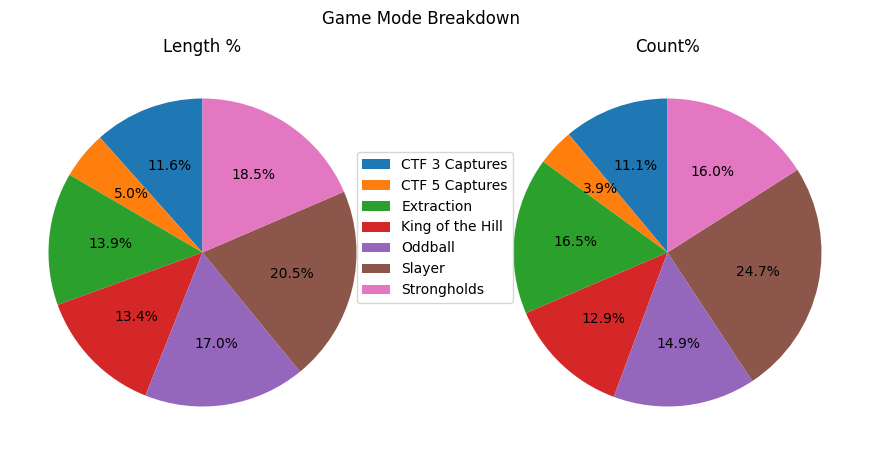

In [54]:
import matplotlib.pyplot as plt

labels = dfrc.index.get_level_values('Category').tolist()
sizes_length = dfrc['Length%'].tolist()
sizes_count = dfrc['Count%'].tolist()

fig, ax = plt.subplots(1, 2, figsize=(11, 5))  # Create a subplot with 1 row and 2 columns
ax[0].pie(sizes_length, labels=None, autopct='%1.1f%%', startangle=90)
ax[1].pie(sizes_count, labels=None, autopct='%1.1f%%', startangle=90)
fig.suptitle('Game Mode Breakdown')
ax[0].set(aspect="equal", title='Length %')
ax[1].set(aspect="equal", title='Count%')
fig.legend(labels, loc="center")

plt.show()

In [55]:
dfrc = dfr.groupby(['Category','Map']).agg({'Category': 'count', 'LengthMinutes': 'sum', 'Outcome': 'mean'})
dfrc.rename(columns={'Category': 'Count', 'LengthMinutes': 'LengthHours'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthHours']/60,2)
dfrc['Outcome'] = round(dfrc['Outcome'],2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc['Length%'] = round(dfrc['LengthHours'] / dfrc['LengthHours'].sum() * 100,2)
dfrc = dfrc.sort_values(['Length%'], ascending=False)
dfrc

,,Count,LengthHours,Outcome,Count%,Length%
Category,Map,,,,,
Strongholds,Solitude,29,6.16,0.38,7.47,9.21
Oddball,Streets,25,5.04,0.56,6.44,7.54
Slayer,Aquarius,34,4.84,0.62,8.76,7.24
King of the Hill,Recharge,22,4.42,0.64,5.67,6.61
Extraction,Streets,30,4.31,0.60,7.73,6.45
Slayer,Solitude,28,4.12,0.54,7.22,6.16
Strongholds,Recharge,18,3.42,0.39,4.64,5.11
CTF 5 Captures,Aquarius,15,3.33,0.33,3.87,4.98
Oddball,Recharge,17,3.30,0.47,4.38,4.93


In [66]:
dfrcc = dfr.groupby(['Category','Map']).agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             'LengthMinutes': 'sum',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Kills/10Min'] = dfrcc['Kills'] / dfrcc['LengthMinutes'] * 10
dfrcc['Deaths/10Min'] = dfrcc['Deaths'] / dfrcc['LengthMinutes'] * 10
dfrcc['Assists/10Min'] = dfrcc['Assists'] / dfrcc['LengthMinutes'] * 10
dfrcc['KDA/10Min'] = (dfrcc['Kills/10Min'] + (dfrcc['Assists/10Min'] / 3)) / dfrcc['Deaths/10Min'] 
# dfrcc = round(dfrcc.sort_values(['Winrate', 'Kills'], ascending=False),2)
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

Count  Kills  Deaths  Assists  DamageDone  \
Category         Map                                                    
King of the Hill Live Fire     17    227     219      109       75568   
Slayer           Recharge       7     64      64       51       27933   
                 Streets       13    121     111       87       46776   
CTF 3 Captures   Forbidden     12    175     117       66       59534   
King of the Hill Recharge      22    409     358      270      140515   
Slayer           Aquarius      34    368     337      217      141574   
Strongholds      Live Fire     15    241     206       98       82304   
Extraction       Streets       30    400     320      226      131462   
                 Recharge      17    213     176      140       74846   
Oddball          Live Fire     16    240     238      165       90905   
                 Streets       25    427     397      269      152837   
Slayer           Solitude      28    300     308      184      116005   
CTF 3 Captures   Argyle        14    189     172       91       68720   
Oddball          Recharge      17    265     226      160       96026   
King of the Hill Solitude      11    216     152      105       66628   
Slayer           Live Fire     14    141     139       75       52742   
CTF 3 Captures   Empyrean      17    229     231      137       83856   
Strongholds      Recharge      18    261     269      169       99629   
                 Solitude      29    563     489      313      188927   
Extraction       Live Fire     17    205     198      115       74027   
CTF 5 Captures   Aquarius      15    307     237      144      104140   

                            DamageTaken  Winrate  LengthMinutes    KD  \
Category         Map                                                    
King of the Hill Live Fire        71454     0.76         151.03  1.04   
Slayer           Recharge         25951     0.71          63.57  1.00   
                 Streets          40174     0.69         100.95  1.09   
CTF 3 Captures   Forbidden        44410     0.67         120.88  1.50   
King of the Hill Recharge        121349     0.64         265.27  1.14   
Slayer           Aquarius        123389     0.62         290.15  1.09   
Strongholds      Live Fire        73589     0.60         168.80  1.17   
Extraction       Streets         108951     0.60         258.50  1.25   
                 Recharge         61442     0.59         154.73  1.21   
Oddball          Live Fire        76808     0.56         180.52  1.01   
                 Streets         133531     0.56         302.37  1.08   
Slayer           Solitude        106513     0.54         247.00  0.97   
CTF 3 Captures   Argyle           60551     0.50         159.38  1.10   
Oddball          Recharge         83065     0.47         198.02  1.17   
King of the Hill Solitude         52390     0.45         122.57  1.42   
Slayer           Live Fire        50712     0.43         122.20  1.01   
CTF 3 Captures   Empyrean         76999     0.41         185.23  0.99   
Strongholds      Recharge         88003     0.39         205.17  0.97   
                 Solitude        162115     0.38         369.67  1.15   
Extraction       Live Fire        65538     0.35         146.05  1.04   
CTF 5 Captures   Aquarius         81598     0.33         199.87  1.30   

                            DamageRatio  Dmg/Life  ExDmg/Life  Kills/10Min  \
Category         Map                                                         
King of the Hill Live Fire         1.06    345.06       18.79        15.03   
Slayer           Recharge          1.08    436.45       30.97        10.07   
                 Streets           1.16    421.41       59.48        11.99   
CTF 3 Captures   Forbidden         1.34    508.84      129.26        14.48   
King of the Hill Recharge          1.16    392.50       53.54        15.42   
Slayer           Aquarius          1.15    420.10       53.96        12.68   
Strongholds      Live Fire         1.12    3

In [57]:
dfrcc = dfr.groupby('Category').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,ExDmg/Life
Category,,,,,,,,,,,
King of the Hill,50,852,729,484,282711,245193,0.64,1.17,1.15,387.81,51.47
Slayer,96,994,959,614,385030,346739,0.58,1.04,1.11,401.49,39.93
Oddball,58,932,861,594,339768,293404,0.53,1.08,1.16,394.62,53.85
Extraction,64,818,694,481,280335,235931,0.53,1.18,1.19,403.94,63.98
CTF 3 Captures,43,593,520,294,212110,181960,0.51,1.14,1.17,407.90,57.98
Strongholds,62,1065,964,580,370860,323707,0.44,1.10,1.15,384.71,48.91
CTF 5 Captures,15,307,237,144,104140,81598,0.33,1.30,1.28,439.41,95.11


In [63]:
dfrcc = dfr.groupby('Map').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Assists/Life', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Map,,,,,,,,,,,,
Recharge,81,1212,1093,790,438949,379810,0.54,1.11,1.16,401.60,54.11,0.72
Streets,68,948,828,582,331075,282656,0.60,1.14,1.17,399.85,58.48,0.70
Solitude,68,1079,949,602,371560,321018,0.46,1.14,1.16,391.53,53.26,0.63
Aquarius,49,675,574,361,245714,204987,0.53,1.18,1.20,428.07,70.95,0.63
Empyrean,17,229,231,137,83856,76999,0.41,0.99,1.09,363.01,29.68,0.59
Forbidden,12,175,117,66,59534,44410,0.67,1.50,1.34,508.84,129.26,0.56
Live Fire,79,1054,1000,562,375546,338101,0.54,1.05,1.11,375.55,37.44,0.56
Argyle,14,189,172,91,68720,60551,0.50,1.10,1.13,399.53,47.49,0.53


In [59]:
print(f'Runtime: {time.perf_counter() - start}s')

Runtime: 7.203039459000138s
